## Introdução

Neste projeto, nosso objetivo é desenvolver um modelo preditivo para prever o fechamento diário do índice IBOVESPA, utilizando uma abordagem de séries temporais. Os dados históricos serão coletados via biblioteca yfinance, cobrindo o período de cinco anos para capturar padrões relevantes do mercado.

Apresentaremos o processo completo por meio de um storytelling, desde a coleta e preparação dos dados, até a escolha e entrega do modelo final. 

## Objetivo

Nosso objetivo é prever diariamente o fechamento do índice IBOVESPA. Para isso, vamos realizar uma análise exploratória e descritiva dos dados, entendendo melhor o comportamento dos fechamentos ao longo do tempo. A partir desse estudo, vamos identificar o modelo mais adequado para nossas features, buscando alcançar uma precisão acima de 70% em nossas previsões.

## 0.0 Imports

In [333]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import datetime as dt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import statsmodels.api as sm
import xgboost as xgb
from statsmodels.graphics.tsaplots import plot_acf as _plot_acf
import warnings

warnings.filterwarnings("ignore")


In [334]:
import pmdarima as pm
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

## 1.0 Extração e Tratamento dos dados

1.1 Importando o DataSet selecionando o período de 5 Anos.

In [335]:
ticker = yf.Ticker('^BVSP')
df_finance = ticker.history(interval='1d', start='2018-01-01', end='2023-12-31')

In [336]:
df_finance.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

1.3 Retirando o Index para criação de algumas features

In [337]:
df_finance.reset_index(inplace=True)

1.4 Selecionando apenas features desejadas

In [338]:
df_finance = df_finance[['Date','Open','High','Low','Close','Volume']]

1.5 Verificação de dados nulos e Duplicadas

In [339]:
df_finance.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [340]:
df_finance.duplicated().sum()

0

In [341]:
df_finance.shape

(1486, 6)

## 2.0 Analise Descritiva dos dados

Com as estatísticas descritivas, observamos que a mediana é superior à média, o que sugere a presença de outliers que estão puxando a média para baixo. Essa assimetria negativa indica que, embora a maioria dos fechamentos diários esteja acima da média, existem valores extremos que afetam essa média.

Além disso, o desvio padrão é relativamente alto, indicando que os fechamentos diários apresentam uma considerável dispersão em relação à média. Isso sugere uma volatilidade significativa nos preços, o que é comum em mercados financeiros. Portanto, precisamos considerar essas características ao modelar os dados, talvez aplicando transformações para lidar com a assimetria e escolhendo modelos que possam capturar essa volatilidade.

In [342]:
df_finance.describe()


,Open,High,Low,Close,Volume
count,1486.000000,1486.000000,1486.000000,1486.000000,1.486000e+03
mean,103619.650740,104603.942127,102657.997981,103656.431359,8.761331e+06
std,14313.414935,14246.088211,14366.744294,14316.872524,4.300705e+06
min,63604.000000,67604.000000,61691.000000,63570.000000,0.000000e+00
25%,95387.500000,96383.500000,94375.500000,95394.000000,4.855225e+06
50%,105514.500000,106584.000000,104504.500000,105530.500000,8.983200e+06
75%,114808.500000,115527.750000,113462.250000,114815.500000,1.171100e+07
max,134194.000000,134392.000000,133832.000000,134194.000000,2.602930e+07


In [343]:
media = df_finance['Close'].mean()
mediana = df_finance['Close'].median()
desvio_padrao = df_finance['Close'].std()
minimo = df_finance['Close'].min()
maximo = df_finance['Close'].max()

print(f"Média do Fechamento: {media}")
print(f"Mediana do Fechamento: {mediana}")
print(f"Desvio Padrão do Fechamento: {desvio_padrao}")
print(f"Valor Mínimo do Fechamento: {minimo}")
print(f"Valor Máximo do Fechamento: {maximo}")

Média do Fechamento: 103656.43135935397
Mediana do Fechamento: 105530.5
Desvio Padrão do Fechamento: 14316.872524207578
Valor Mínimo do Fechamento: 63570.0
Valor Máximo do Fechamento: 134194.0


Observamos que a assimetria do fechamento é negativa, o que confirma que a maior parte dos dados está acima da média. Além disso, a kurtose negativa indica que a distribuição dos valores de fechamento possui caudas mais leves do que uma distribuição normal.

In [344]:
assimetria = df_finance['Close'].skew()
curtose = df_finance['Close'].kurt()

print(f"Assimetria do Fechamento: {assimetria}")
print(f"Curtose do Fechamento: {curtose}")


Assimetria do Fechamento: -0.4545900325829013
Curtose do Fechamento: -0.5489083250746107


No histograma, podemos observar que a maior concentração dos dados está entre 100 mil e 120 mil, indicando que a maior parte dos valores se encontra nessa faixa. Há uma leve assimetria à direita, o que significa que existem alguns valores mais altos fora da faixa principal, embora em menor quantidade.

No boxplot, além de mostrar a dispersão dos dados por meio dos quartis, conseguimos identificar um outlier, ou seja, um valor atípico, que está localizado abaixo de 70 mil. Esse ponto fora do padrão pode ser o valor que está impactando em nossa média levemente para baixo.



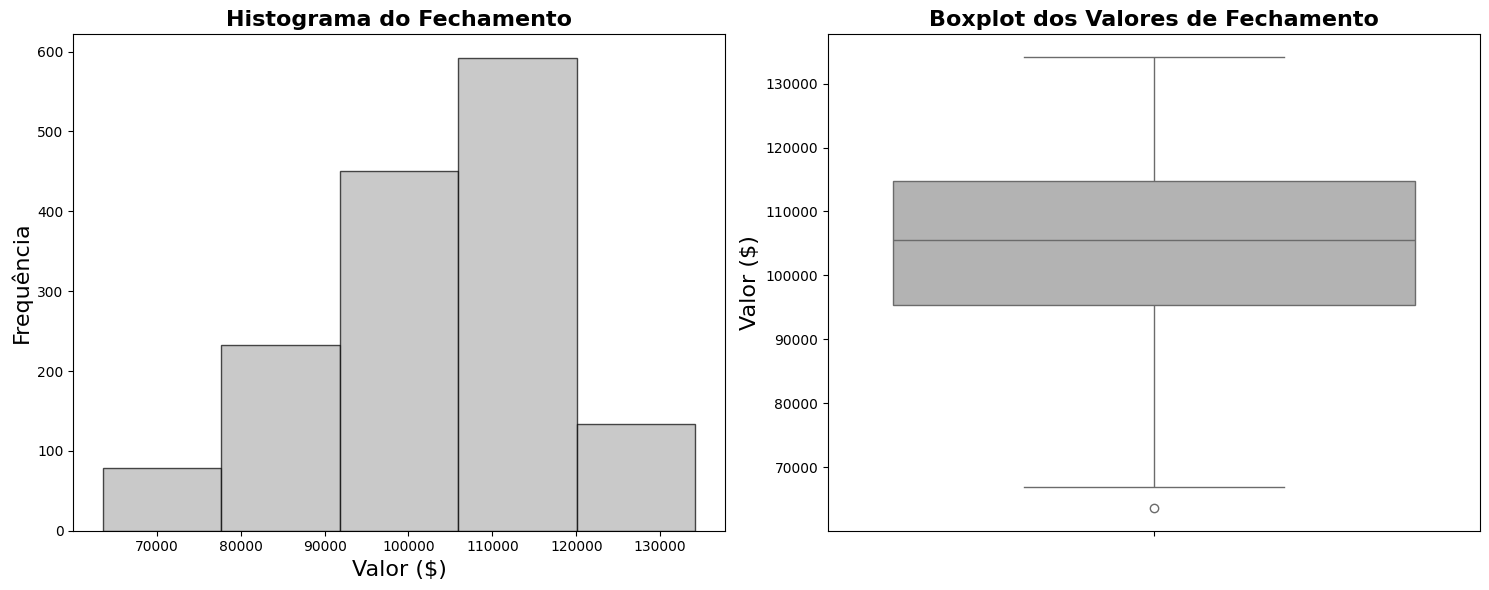

In [345]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
medium_colors = sns.color_palette("Set2")

# Histogram
axes[0].hist(df_finance['Close'], bins=5, color=medium_colors[7], edgecolor='black', alpha=0.7)
axes[0].set_title('Histograma do Fechamento', fontsize=16, weight='bold')
axes[0].set_xlabel('Valor ($)', fontsize=16)
axes[0].set_ylabel('Frequência', fontsize=16)

# Boxplot
sns.boxplot(y='Close', data=df_finance, color=medium_colors[7], ax=axes[1])
axes[1].set_title('Boxplot dos Valores de Fechamento', fontsize=16, weight='bold')
axes[1].set_ylabel('Valor ($)', fontsize=16)

plt.tight_layout()
plt.show()


## 3.0 Análise Explorátoria dos Dados

No gráfico de linhas, podemos observar que, de maneira geral, os valores de fechamento apresentam uma tendência de crescimento ao longo do tempo. No entanto, também é evidente uma alta volatilidade, com várias oscilações ao longo do período. A exceção mais marcante ocorre entre 2020 e 2021, onde há uma queda significativa devido à pandemia de COVID-19, que coincide com o outlier identificado na nossa análise descritiva. 

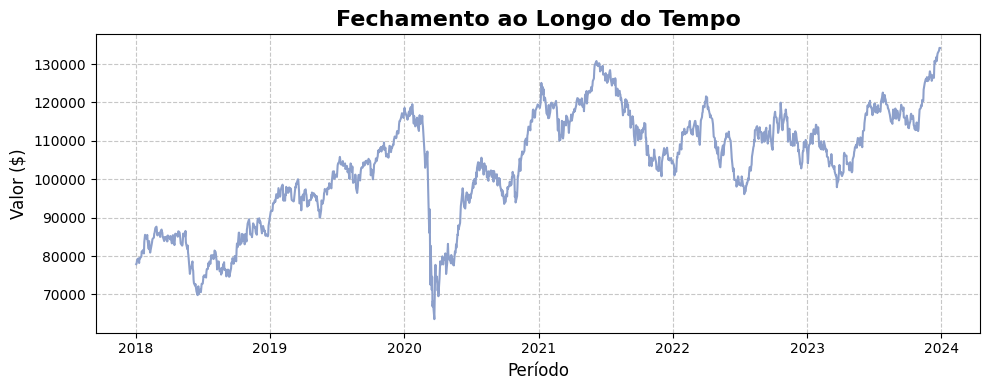

In [346]:
plt.figure(figsize=(10, 4)) 
medium_colors = sns.color_palette("Set2")

sns.lineplot(x='Date', y='Close', color=medium_colors[2], data=df_finance)

plt.title('Fechamento ao Longo do Tempo', fontsize=16, weight='bold')
plt.xlabel('Período', fontsize=12)
plt.ylabel('Valor ($)', fontsize=12)


plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

3.1 Criação de novas Features

In [347]:
df_finance['Ano'] = df_finance['Date'].dt.year

In [348]:
df_finance['Mes'] = df_finance['Date'].dt.month

In [349]:
dicionario = {
    1: 1,
    2: 1,
    3: 1,
    4: 2,
    5: 2,
    6: 2,
    7: 3,
    8: 3,
    9: 3,
    10:4,
    11:4,
    12:4
}
quartil = pd.DataFrame(list(dicionario.items()), columns=['Mes', 'Trimestre'])

In [350]:
df_merged = pd.merge(df_finance, quartil, on='Mes', how='left')

Coluna criada para termos uma suavização dos valores para verificarmos a têndecia dos fechamentos

In [351]:
df_merged['Media_Movel'] = df_merged['Close'].rolling(window=30).mean()

Analisando a série temporal com o uso de uma média móvel a tendência é que o fechamento em dezembro seja consistentemente superior ao de janeiro. Esse padrão sugere uma tendência de crescimento nos valores de fechamento, que se intensifica no final do ano.

Outro ponto relevante é que, ao longo dos primeiros semestres, os fechamento apresentam maior instabilidade e, em alguns momentos, até retração. No entanto, é a partir do meio do ano que os valores de fechamento começam a mostrar uma trajetória de alta mais pronunciada, refletindo, possivelmente, fatores sazonais e econômicos que impulsionam o mercado nesse período.

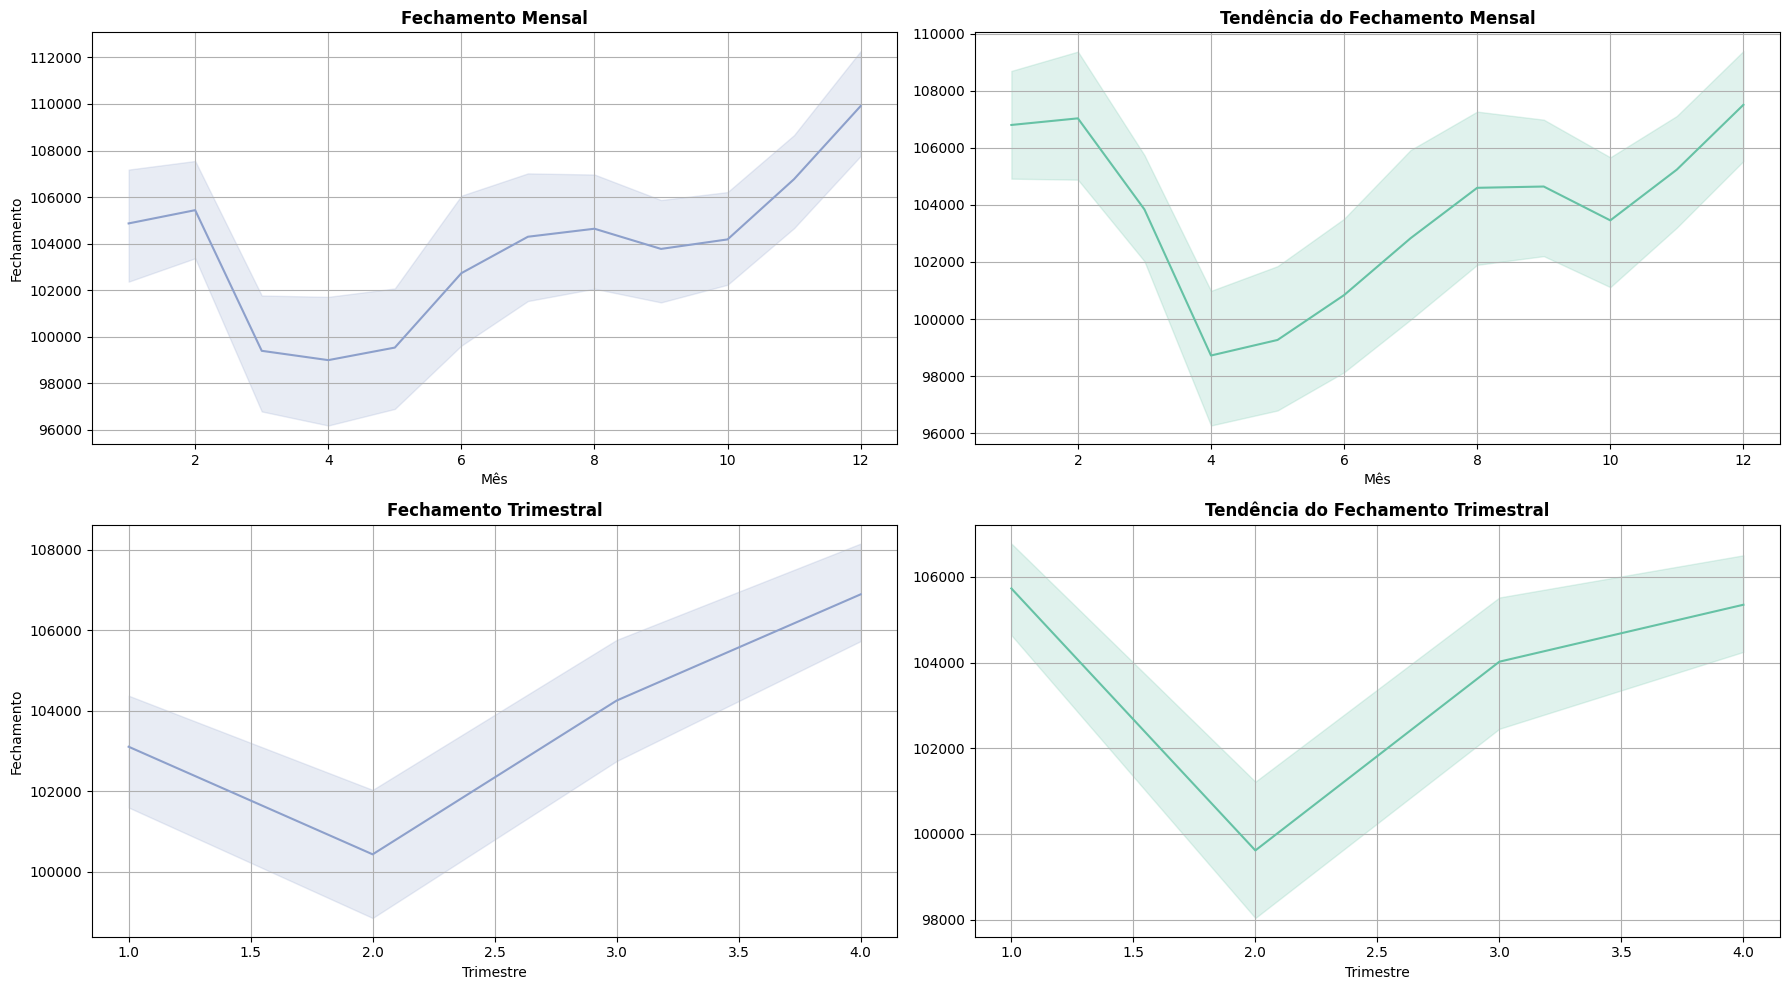

In [352]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
medium_colors = sns.color_palette("Set2")

# Gráfico 1: Tendência do Fechamento Mensal
axes[0, 0].set_title('Fechamento Mensal', weight='bold')
sns.lineplot(data=df_merged,x='Mes',y='Close',ax=axes[0, 0], color=medium_colors[2],)
axes[0, 0].set_xlabel('Mês')
axes[0, 0].set_ylabel('Fechamento')
axes[0, 0].grid(True)

# Gráfico 2: Fechamento Mensal (LinePlot)
sns.lineplot(data=df_merged, x='Mes', y='Media_Movel', ax=axes[0, 1], color=medium_colors[0])
axes[0, 1].set_title('Tendência do Fechamento Mensal', weight='bold')
axes[0, 1].set_xlabel('Mês')
axes[0, 1].set_ylabel('')
axes[0, 1].grid(True)

# Gráfico 3: Tendência do Fechamento Trimestral
axes[1, 0].set_title('Fechamento Trimestral', weight='bold')
sns.lineplot(data=df_merged,x='Trimestre',y='Close',ax=axes[1,0], color=medium_colors[2])
axes[1, 0].set_xlabel('Trimestre')
axes[1, 0].set_ylabel('Fechamento')
axes[1, 0].grid(True)

# Gráfico 4: Fechamento Trimestral (LinePlot)
sns.lineplot(data=df_merged, x='Trimestre', y='Media_Movel', ax=axes[1, 1], color=medium_colors[0])
axes[1, 1].set_title('Tendência do Fechamento Trimestral', weight='bold')
axes[1, 1].set_xlabel('Trimestre')
axes[1, 1].set_ylabel('')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


Agora, vamos considerar um período mais amplo de fechamentos para realizar uma análise comparativa entre anos de eleições presidenciais e anos sem eleições.

In [353]:
ticker = yf.Ticker('^BVSP')
df_periodo_maior = ticker.history(interval='1d', start='2010-01-01', end='2023-12-31')

In [354]:
df_periodo_maior.reset_index(inplace=True)

In [355]:
df_periodo_maior = df_periodo_maior[['Date','Open','High','Low','Close','Volume']]

In [356]:
df_periodo_maior['Ano'] = df_periodo_maior['Date'].dt.year
df_periodo_maior['Mes'] = df_periodo_maior['Date'].dt.month

In [357]:
df_merged_maior = pd.merge(df_periodo_maior, quartil, on='Mes', how='left')

In [358]:
df_eleicao = df_merged_maior[df_merged_maior['Ano'].isin([2010,2014,2018,2022])]

In [359]:
df_nao_eleicao = df_merged_maior[~df_merged_maior['Ano'].isin([2010,2014,2018,2022])]

Comparando os anos de eleição presidencial com os anos sem eleição, observamos algumas tendências distintas no comportamento dos fechamentos da bolsa ao longo do ano.

Em dezembro, há uma tendência notável de queda nos anos de eleição, enquanto no início do ano observamos uma leve alta, contrastando com os anos sem eleição, onde essa elevação não é tão evidente. Este padrão sugere que a incerteza política associada ao período eleitoral pode impactar negativamente os preços no final do ano, refletindo a cautela dos investidores diante de possíveis mudanças nas políticas econômicas.

Outro ponto crucial é que, nos anos de eleição, as altas nos fechamentos só começam a se manifestar a partir do terceiro trimestre, em comparação com os anos sem eleição, onde já notamos uma recuperação a partir do segundo trimestre. Essa diferença no timing das recuperações sugere que o clima político e a expectativa sobre os resultados das eleições podem atrasar a recuperação do mercado.

Esses padrões indicam que o impacto das eleições pode criar um efeito sazonal significativo nos fechamentos da bolsa.
O comportamento observado nos últimos meses de um ano eleitoral, aliado à demora na recuperação, pode indicar que as incertezas políticas não só influenciam as decisões dos investidores, mas também afetam a performance da nossa base de dados ao longo do tempo.

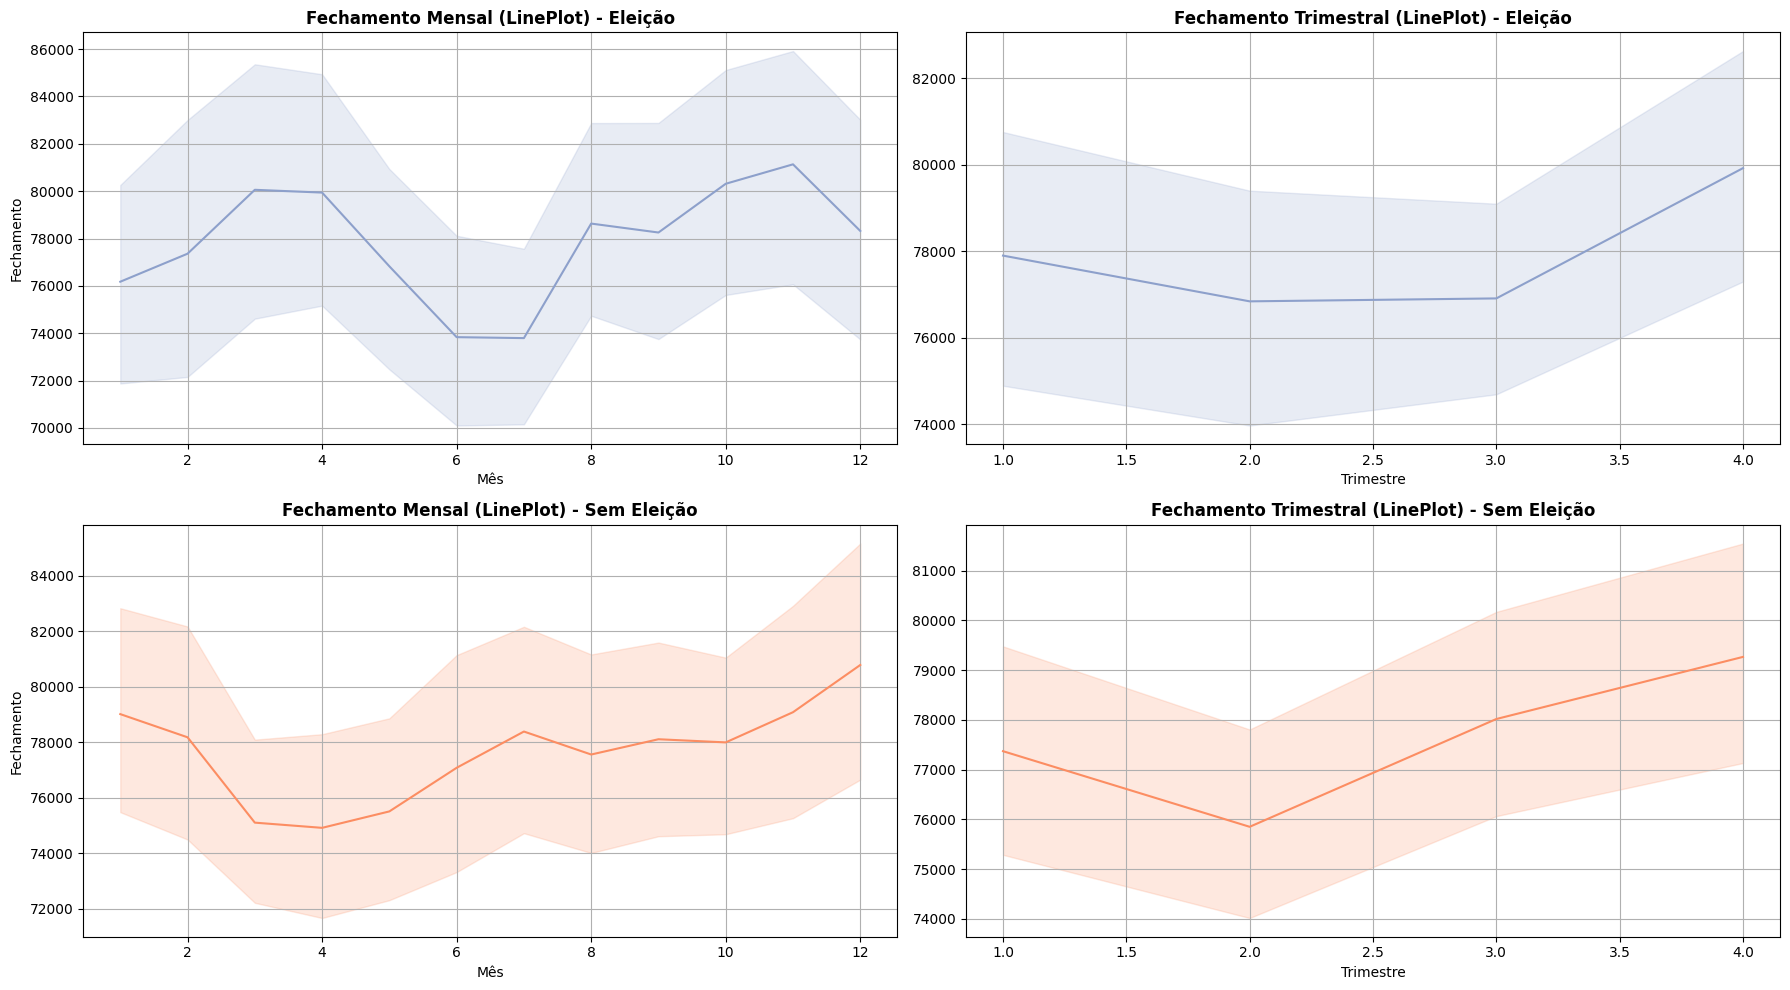

In [360]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Gráfico 1: Fechamento Mensal para anos de Eleição
sns.lineplot(data=df_eleicao, x='Mes', y='Close', ax=axes[0, 0], color=medium_colors[2])
axes[0, 0].set_title('Fechamento Mensal (LinePlot) - Eleição', weight='bold')
axes[0, 0].set_xlabel('Mês')
axes[0, 0].set_ylabel('Fechamento')
axes[0, 0].grid(True)

# Gráfico 2: Fechamento Trimestral para anos de Eleição
sns.lineplot(data=df_eleicao, x='Trimestre', y='Close', ax=axes[0, 1], color=medium_colors[2])
axes[0, 1].set_title('Fechamento Trimestral (LinePlot) - Eleição', weight='bold')
axes[0, 1].set_xlabel('Trimestre')
axes[0, 1].set_ylabel('')
axes[0, 1].grid(True)

# Gráfico 3: Fechamento Mensal para anos sem Eleição
sns.lineplot(data=df_nao_eleicao, x='Mes', y='Close', ax=axes[1, 0], color=medium_colors[1])
axes[1, 0].set_title('Fechamento Mensal (LinePlot) - Sem Eleição', weight='bold')
axes[1, 0].set_xlabel('Mês')
axes[1, 0].set_ylabel('Fechamento')
axes[1, 0].grid(True)

# Gráfico 4: Fechamento Trimestral para anos sem Eleição
sns.lineplot(data=df_nao_eleicao, x='Trimestre', y='Close', ax=axes[1, 1], color=medium_colors[1])
axes[1, 1].set_title('Fechamento Trimestral (LinePlot) - Sem Eleição', weight='bold')
axes[1, 1].set_xlabel('Trimestre')
axes[1, 1].set_ylabel('')
axes[1, 1].grid(True)

# Ajustando o layout
plt.tight_layout()
plt.show()

No gráfico de calor, analisamos as correlações entre diversas variáveis e nossa variável alvo, o fechamento diário da IBOVESPA ("Close"). Observamos que várias features apresentam uma correlação forte com o fechamento, mas não podemos utilizar todas no modelo, já que algumas variáveis, como "High" ou "Low", só são conhecidas no final do dia. Utilizá-las poderia introduzir um viés, comprometendo a validade das previsões.

Por isso, vamos focar em variáveis que estão disponíveis no início do dia, "Open" (valor de abertura) e as variáveis de Data. Dessa forma, podemos construir um modelo mais robusto, utilizando informações acessíveis antes do fechamento e evitando influências indevidas nos resultados.

In [361]:
correlation_matrix = df_merged_maior.corr(numeric_only=True)


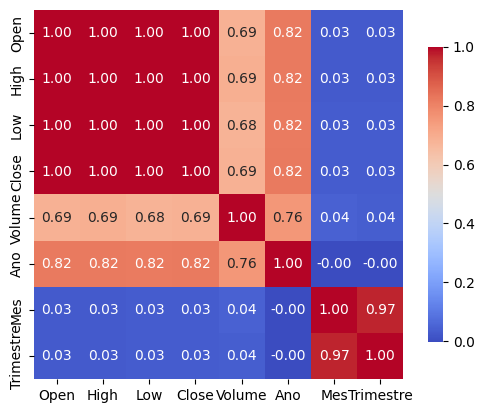

In [362]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})

plt.show()

## 4.0 Preparações para o Modelo

4.1 Decomposição da Série Temporal

In [363]:
df_dataset = df_finance[['Date','Open','Close']]

In [364]:
df_dataset['Date'] = df_dataset['Date'].dt.date

In [365]:
min = df_dataset['Date'].min()
max = df_dataset['Date'].max()

print('Data Min: ',min,'Data Max: ',max)

Data Min:  2018-01-02 Data Max:  2023-12-28


Função para obtermos o reultado dos modelos

In [366]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape:.2f} %")

Nos gráficos gerados pela função seasonal_decompose, podemos realizar diversas análises. 

O primeiro gráfico apresenta os dados brutos, onde podemos observar a volatilidade presente. 
No segundo gráfico, observamos a tendência dos dados, que mostra um aumento quase contínuo nos fechamentos ao longo do tempo. 
O terceiro gráfico revela a sazonalidade, onde, ao considerar um intervalo de 250 dias, identificamos padrões que se repetem anualmente, indicando como os fechamentos podem variar em diferentes períodos do ano. 
Por fim, o último gráfico ilustra os ruídos dos dados, representando as flutuações aleatórias que não são capturadas pela tendência ou pela sazonalidade.

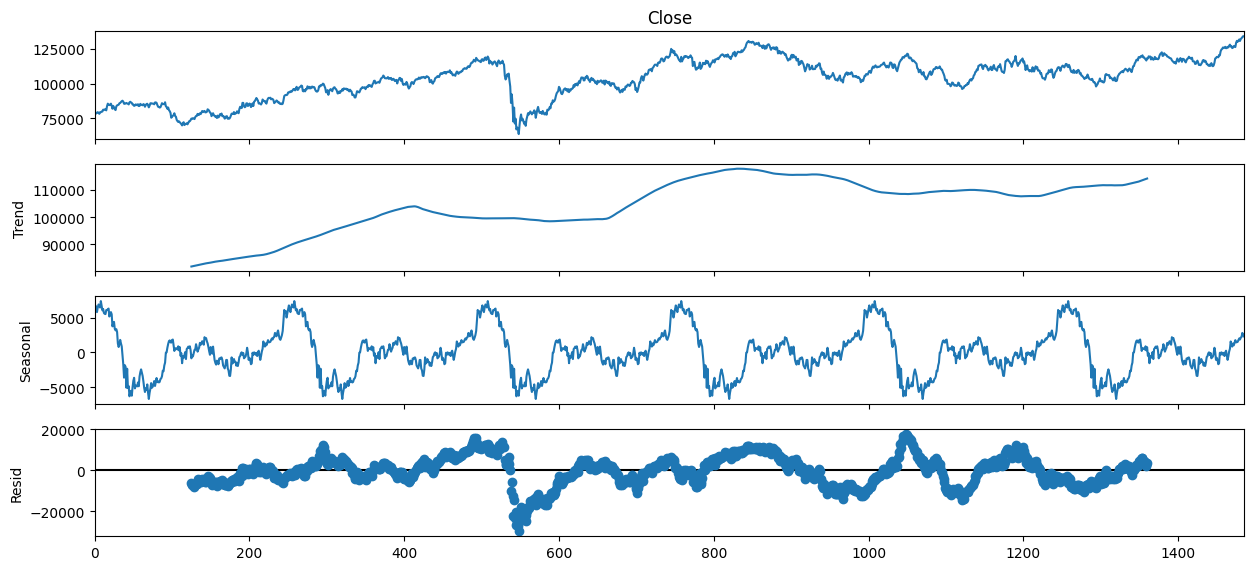

In [367]:
# Decomposição da série temporal
result = seasonal_decompose(df_dataset["Close"], model="additive", period=250)
fig = result.plot()
fig.set_size_inches(14, 6)

Criamos uma função para medir a autocorrelação da nossa variável Close. Observamos que a autocorrelação diminui ao longo do tempo, o que é normal, uma vez que nossa base apresenta uma tendência. Essa redução gradual ao longo dos dias indica que os valores se tornam menos correlacionados à medida que nos afastamos de um ponto no tempo.

Essa informação é muito importante, pois irá nos ajudar a definir nosso valor de Q do modelo ARIMA.

In [368]:
def plot_acf(data, lags=250, title="Autocorrelação da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))
    
    _plot_acf(data, lags=lags, color=medium_colors[2],ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.acf(data, alpha=0.05, nlags=250)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"The ACF coefficients intercept the threshold at lag {intercept_point[0][0]}"
        )
    else:
        print("The ACF coefficients do not intercept the threshold")

The ACF coefficients intercept the threshold at lag 91


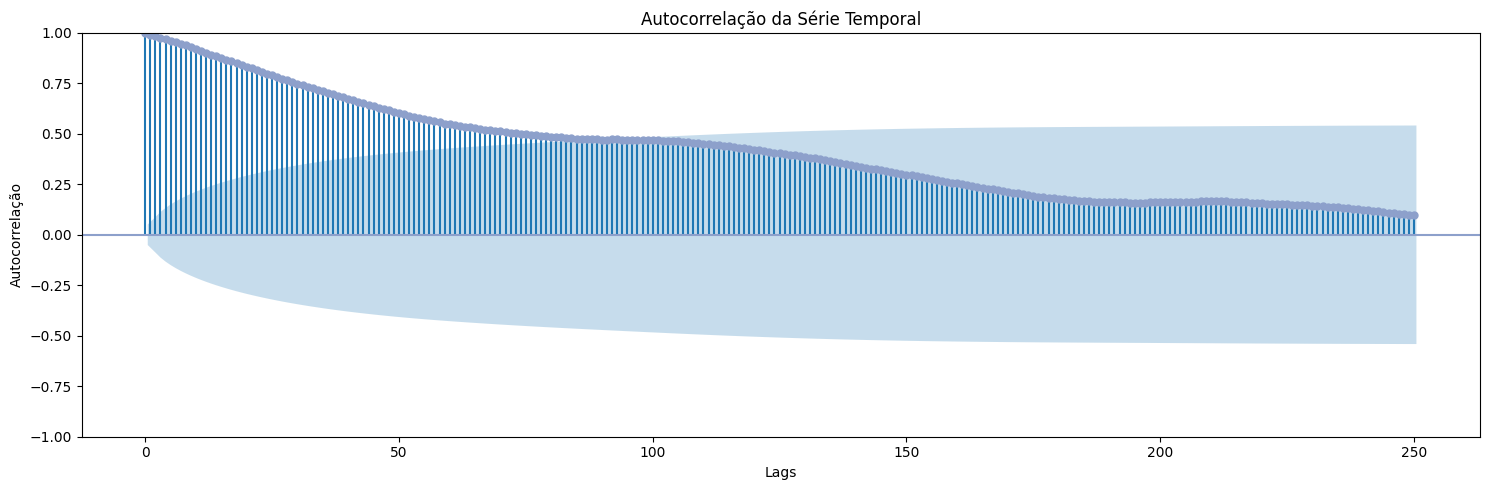

In [369]:
plot_acf(df_dataset["Close"])

Neste gráfico, apresentamos a autocorrelação da série temporal sem incluir valores intermediários. Essa representação nos ajuda a identificar a estrutura temporal dos dados, permitindo a definição mais precisa dos parâmetros para o nosso modelo ARIMA.

Em particular, essa análise nos fornece informações cruciais sobre o valor de P, que se refere ao número de lags significativos do componente autorregressivo sazonal do modelo.

In [370]:
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf

def plot_pacf(data, lags=30, title="Autocorrelação Parcial da Série Temporal"):
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    _plot_pacf(data, lags=lags,color=medium_colors[2], ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação Parcial")
    
    fig.tight_layout()
    
    pacf_values, confidence_intervals = sm.tsa.pacf(data, alpha=0.05, nlags=lags)[:2]
    
    intercept_point = np.where(abs(pacf_values) < (confidence_intervals[:, 1] - pacf_values))
    
    if intercept_point[0].size > 0:
        print(f"Os coeficientes do PACF interceptam o limiar no lag {intercept_point[0][0]}")
    else:
        print("Os coeficientes do PACF não interceptam o limiar de confiança.")
    
    plt.show()

Os coeficientes do PACF interceptam o limiar no lag 3


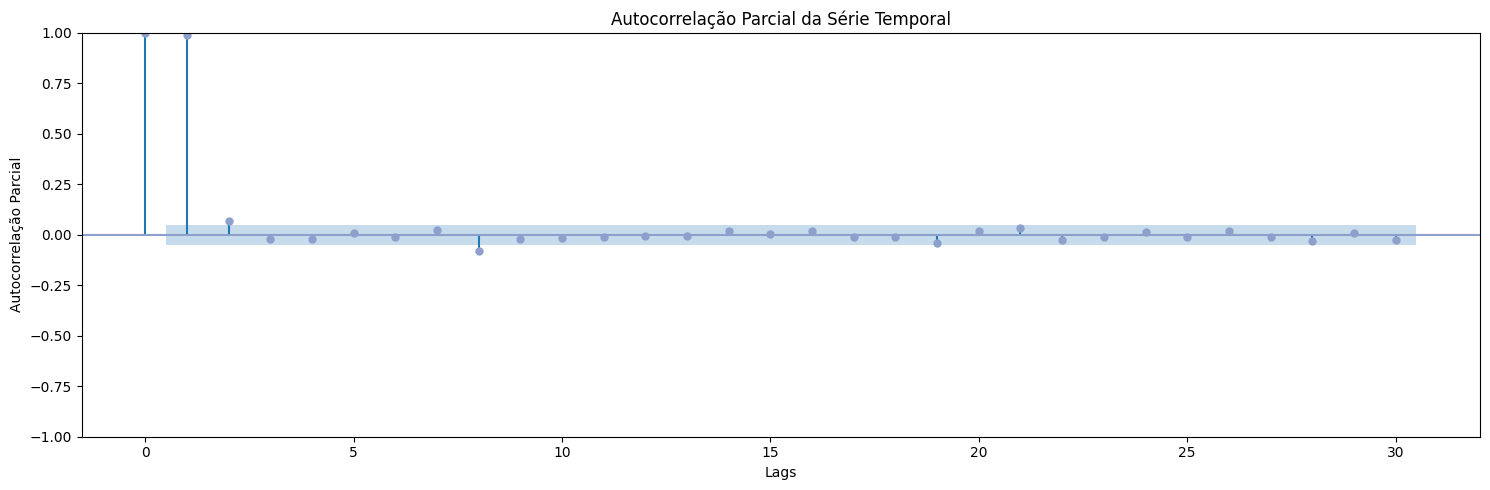

In [371]:
plot_pacf(df_dataset["Close"])

Observando abaixo, podemos concluir que a série temporal analisada não é estacionária. Para modelá-la adequadamente com ARIMA, será necessário aplicar transformações, como diferenciação ou logaritmização, para torná-la estacionária antes da modelagem.

In [372]:
adf_result = sm.tsa.adfuller(df_dataset["Close"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -2.0974038443235727
p-value: 0.24555980941571626
Critical Values: {'1%': -3.434785139702456, '5%': -2.863498825305098, '10%': -2.5678128583805213}
A série temporal não é estacionária


Após realizar o teste de estacionariedade, concluímos que foi necessária apenas uma diferenciação para tornar a série temporal estacionária. Isso nos permite definir o valor de D (diferenciação sazonal) para o nosso modelo ARIMA.

In [373]:
adf_result = sm.tsa.adfuller(df_dataset["Close"].diff().dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -11.947521316564544
p-value: 4.394627144539277e-22
Critical Values: {'1%': -3.434785139702456, '5%': -2.863498825305098, '10%': -2.5678128583805213}
A série temporal é estacionária


Nesse bloco atribuimos os valores de P,Q e D

In [374]:
acf_x = sm.tsa.acf(df_dataset["Close"], alpha=0.05, nlags=250)
acf, ci = acf_x[:2]
# identificação do q pelo ponto de interceptação ao 95% com o acf
q = np.where(abs(acf) < (ci[:, 1] - acf))[0][0]

pacf_x = sm.tsa.pacf(df_dataset["Close"], alpha=0.05, nlags=30)
pacf, ci = pacf_x[:2]
# identificação do p pelo ponto de interceptação ao 95% com o pacf
p = np.where(abs(pacf) < (ci[:, 1] - pacf))[0][0]

d = 1  # apenas 1 diferenciação foi necessária para tornar a série estacionária

In [375]:
p, q, d

(3, 91, 1)

## 5.0 Aplicando os modelos

## ARIMA

O modelo ARIMA é uma abordagem robusta para a previsão de séries temporais, utilizando a autoregressão da variável-alvo para estimar futuros valores. Nesta fase do nosso trabalho, iremos focar na avaliação da performance do modelo com base nas autocorrelações presentes nos dados.

Este modelo utiliza a autoregressão (AR) para estimar o valor atual com base em valores passados. A diferenciação (I) é aplicada para remover tendências do modelo, enquanto a média móvel (MA) ajusta as previsões com base nos erros das previsões anteriores.


In [376]:
df_dataset["Date"] = pd.to_datetime(df_dataset["Date"])

In [377]:
df_arima = df_dataset

Nesse bloco separamos nossa base de Treino e Teste

In [378]:
train_size = df_arima.shape[0] - 30
train, test = df_arima[:train_size], df_arima[train_size:]

In [379]:
print('Data mínima Treino:',train['Date'].min())
print('Data máxima Treino:',train['Date'].max())

Data mínima Treino: 2018-01-02 00:00:00
Data máxima Treino: 2023-11-14 00:00:00


In [380]:
print('Data mínima Teste:',test['Date'].min())
print('Data máxima Teste:',test['Date'].max())

Data mínima Teste: 2023-11-16 00:00:00
Data máxima Teste: 2023-12-28 00:00:00


In [381]:
train_series = train["Close"]
test_series = test["Close"]


Nessa função, iremos captar a melhor opção que temos de P,D e Q, para não deixar o modelo pesado ou enviesado.

In [382]:
from pmdarima import auto_arima

model_auto = auto_arima(df_arima['Close'],
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        d=None,             # O auto_arima determina o valor de 'd'
                        seasonal=False,     # Como não queremos o SARIMA aqui
                        trace=True,         # Para ver o progresso do ajuste
                        error_action='ignore', 
                        suppress_warnings=True,
                        stepwise=True)      # Stepwise faz o processo de seleção ser mais rápido

print(model_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26032.867, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26026.456, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26026.847, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26031.757, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=26027.132, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26027.794, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26028.556, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=26025.556, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=26026.143, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=26026.828, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=26025.946, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=26024.500, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=26028.617, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.99 sec
 ARIMA(1,1,2)(0,0,0)[0]  

Nesse bloco, definimos os parâmetros para o modelo ARIMA, ajustando o valor de Q para um nível mais baixo. Essa decisão foi tomada para otimizar o tempo de processamento, já que valores altos de Q podem resultar em um aumento significativo na complexidade do modelo e no tempo de execução. Um Q menor permite capturar a autocorrelação dos erros de previsão em um intervalo mais curto, evitando o risco de sobreajuste e melhorando a eficiência computacional. Assim, buscamos equilibrar a capacidade do modelo de capturar padrões relevantes nos dados sem comprometer a performance.

In [383]:
# Definindo os valores de p, d e q
p = 2  
d = 1
q = 1 

# Treinando o modelo ARIMA
model = sm.tsa.ARIMA(train_series, order=(p, d, q))
arima_model = model.fit()

# Prevendo para o conjunto de teste
preds_arima = arima_model.forecast(steps=len(test_series))


 O resultado do nosso modelo foi positivo, porém, acreditamos que ainda há espaço para melhorias. Uma exploração mais abrangente dos parâmetros (P,D,Q) poderia potencialmente otimizar ainda mais o desempenho do modelo.

In [384]:
# Avaliação ARIMA
metrics_arima = calculate_metrics(test_series, preds_arima)
print("ARIMA Metrics:")
print_metrics(metrics_arima)


ARIMA Metrics:
MAE: 4381.068779431128
MSE: 26737525.461935993
MAPE: 3.37 %


In [385]:
resultado_arima = test[["Date","Close"]]
resultado_arima["Predict"] = preds_arima 

In [386]:
resultado_arima.head(10)

,Date,Close,Predict
1456,2023-11-16,124576.0,123229.736384
1457,2023-11-17,125062.0,123349.280009
1458,2023-11-20,126095.0,123441.357441
1459,2023-11-21,125607.0,123525.554040
1460,2023-11-22,126035.0,123601.372452
1461,2023-11-23,126576.0,123669.733507
1462,2023-11-24,125542.0,123731.364119
1463,2023-11-27,125683.0,123786.927423
1464,2023-11-28,126538.0,123837.020687
1465,2023-11-29,126101.0,123882.182424


## SARIMA

O modelo SARIMA é uma extensão do modelo ARIMA que permite a inclusão de sazonalidade. Essa característica possibilita capturar melhor os padrões da série temporal, tornando as previsões mais precisas ao considerar variações que ocorrem em intervalos regulares.


In [387]:
df_sarima = df_dataset

In [388]:
train_size = df_sarima.shape[0] - 30
train, test = df_sarima[:train_size], df_sarima[train_size:]


In [389]:
train_series = train["Close"]
test_series = test["Close"]


In [390]:
print('Data mínima Treino:',train['Date'].min())
print('Data máxima Treino:',train['Date'].max())

Data mínima Treino: 2018-01-02 00:00:00
Data máxima Treino: 2023-11-14 00:00:00


In [391]:
print('Data mínima Teste:',test['Date'].min())
print('Data máxima Teste:',test['Date'].max())

Data mínima Teste: 2023-11-16 00:00:00
Data máxima Teste: 2023-12-28 00:00:00


Neste trecho, identificamos o menor valor de AIC na saída para evitar que o modelo sofra com sobreajuste. O AIC ajuda a encontrar um equilíbrio entre um bom ajuste aos dados e a simplicidade do modelo, minimizando o risco de overfitting. O objetivo é escolher uma combinação de parâmetros que proporcione uma boa performance, mantendo o modelo o mais simples e eficiente possível.

In [392]:
from pmdarima import auto_arima

model_auto = auto_arima(df_sarima['Close'],
                         seasonal=True,    # Ativa a sazonalidade
                         m=12,             # Frequência sazonal 
                         trace=True,       # Para visualizar o progresso do ajuste
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)    # Método stepwise para busca rápida

print(model_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.91 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=26032.867, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=26028.422, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=26028.816, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=26031.757, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=26026.456, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=26028.423, Time=0.19 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=26029.954, Time=0.87 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=26027.132, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=26027.794, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=26026.847, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=26028.556, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=26025.556, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=26027.533, Time=0.11 sec
 ARIMA(1,1,

No bloco de código abaixo, definimos os parâmetros para o modelo SARIMA, especificamos os valores de p, d, q para capturar a autocorrelação regular, e os valores de P, D, Q e S para lidar com a autocorrelação sazonal.

In [393]:
import statsmodels.api as sm

p = 2  # AR regular
d = 1  # Diferença regular
q = 1  # MA regular
P = 2  # AR sazonal
D = 1  # Diferença sazonal
Q = 1  # MA sazonal
S = 12 # Sazonalidade 



# Treinando o modelo SARIMA
model = sm.tsa.SARIMAX(train_series, order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_model = model.fit()

# Prevendo no conjunto de teste
preds_sarima = sarima_model.forecast(steps=len(test_series))

Observamos uma melhora no desempenho das previsões utilizando o modelo SARIMA ao incluir a sazonalidade, capturando padrões cíclicos nos dados. Enquanto o ARIMA lida bem com tendências e autocorrelações, o SARIMA se mostrou mais eficaz para séries temporais com ciclos recorrentes, como o IBOVESPA, que é influenciado por eventos periódicos.

In [394]:
metrics_sarima = calculate_metrics(test_series, preds_sarima)
print("SARIMA Metrics:")
print_metrics(metrics_sarima)

SARIMA Metrics:
MAE: 1863.497359839529
MSE: 5334846.358715939
MAPE: 1.43 %


In [395]:
resultado_sarima = test[["Date","Close"]]
resultado_sarima["Predict"] = preds_sarima 

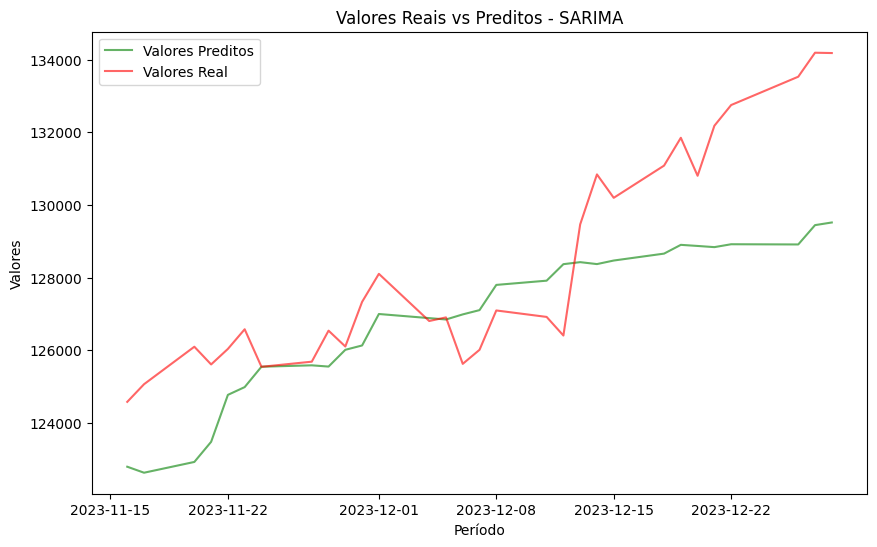

In [396]:
plt.figure(figsize=(10, 6))

plt.plot(resultado_sarima['Date'],resultado_sarima['Predict'], label="Valores Preditos", color="Green", alpha=0.6)
plt.plot(resultado_sarima['Date'],resultado_sarima['Close'], label="Valores Real", color="red", alpha=0.6)

plt.title("Valores Reais vs Preditos - SARIMA")
plt.xlabel("Período")
plt.ylabel("Valores")
plt.legend()

plt.show()

In [397]:
resultado_sarima.head(10)

,Date,Close,Predict
1456,2023-11-16,124576.0,122789.333757
1457,2023-11-17,125062.0,122624.046981
1458,2023-11-20,126095.0,122920.836731
1459,2023-11-21,125607.0,123475.246732
1460,2023-11-22,126035.0,124768.736746
1461,2023-11-23,126576.0,124982.707081
1462,2023-11-24,125542.0,125544.121074
1463,2023-11-27,125683.0,125582.544174
1464,2023-11-28,126538.0,125548.156794
1465,2023-11-29,126101.0,126010.004894


## SARIMAX

O **SARIMAX** é uma extensão do modelo SARIMA que permite a inclusão de variáveis exógenas (regressores), além de considerar a sazonalidade. 

Essa flexibilidade possibilita ao modelo capturar não apenas os padrões sazonais da série temporal, mas também a influência de fatores externos, melhorando a precisão das previsões.

In [398]:
df_sarimax = df_dataset

In [399]:
train_size = df_sarimax.shape[0] - 30
train, test = df_sarimax[:train_size], df_sarimax[train_size:]

In [400]:
print('Data mínima Treino:',train['Date'].min())
print('Data máxima Treino:',train['Date'].max())

Data mínima Treino: 2018-01-02 00:00:00
Data máxima Treino: 2023-11-14 00:00:00


In [401]:
print('Data mínima Teste:',test['Date'].min())
print('Data máxima Teste:',test['Date'].max())

Data mínima Teste: 2023-11-16 00:00:00
Data máxima Teste: 2023-12-28 00:00:00


In [402]:
# Preparar as séries de treino e teste
base_treino = train[["Close","Open"]]
base_teste = test[["Close","Open"]]

No modelo SARIMAX, utilizaremos os mesmos parâmetros que aplicamos no SARIMA, mas agora adicionaremos a variável exógena "Open", que representa o valor de abertura obtido no início de cada dia.

In [403]:
# Modelo SARIMAX
exog_train = base_treino[["Open"]]
exog_test = base_teste[["Open"]]

model = sm.tsa.statespace.SARIMAX(
    base_treino["Close"],
    exog=exog_train,
    order=(
        2,
        1,
        1,
    ),  
    seasonal_order=(2, 1, 1, 12),
)
results = model.fit()

preds_sarimax = results.get_forecast(steps=len(base_teste), exog=exog_test).predicted_mean

metrics_sarimax = calculate_metrics(base_teste["Close"], preds_sarimax)

À primeira vista, os resultados do modelo SARIMAX parecem excelentes. No entanto, é importante termos cuidado, pois há a possibilidade de que o modelo tenha sofrido overfitting. Como inserimos mais parâmetros, a complexidade do modelo pode ter aumentado, o que pode levar a uma incapacidade de generalizar adequadamente para novos dados. 

In [404]:
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)

SARIMAX Metrics:
MAE: 1033.803464301617
MSE: 1647890.0289769892
MAPE: 0.80 %


Analisando as métricas do modelo com a base de treino. Os resultados não indicam overfitting, pois a performance de treinamento está relativamente próxima à performance de teste. Além disso, é positivo observar que o modelo teve um desempenho melhor na base de teste do que na de treinamento, sugerindo que ele está generalizando bem e capturando padrões relevantes nos dados.

In [405]:
preds_train = results.fittedvalues
metrics_train = calculate_metrics(base_treino["Close"], preds_train)
print("SARIMAX Training Metrics:")
print_metrics(metrics_train)


SARIMAX Training Metrics:
MAE: 1189.3263111789752
MSE: 2658902.1069547115
MAPE: 1.20 %


In [406]:
resultado_sarimax = test[["Date","Close"]]
resultado_sarimax["Predict"] = preds_sarimax 

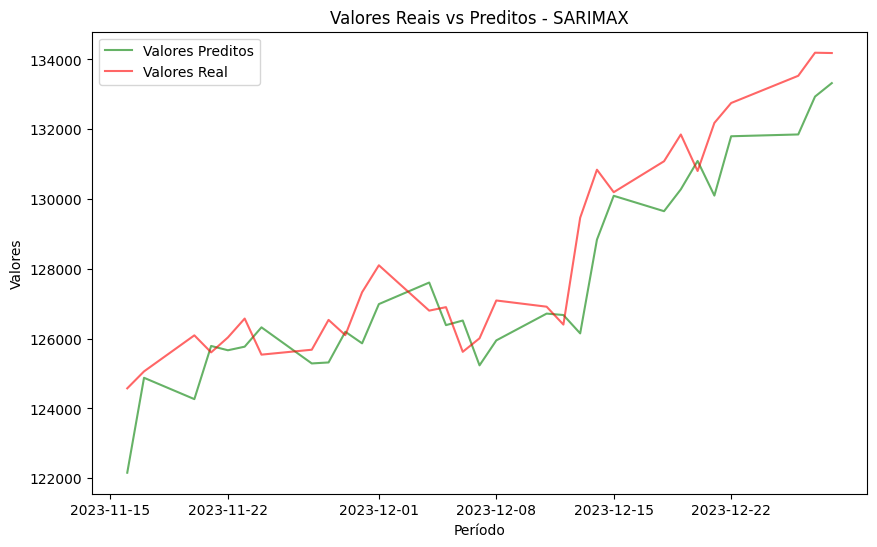

In [407]:
plt.figure(figsize=(10, 6))

plt.plot(resultado_sarimax['Date'],resultado_sarimax['Predict'], label="Valores Preditos", color="Green", alpha=0.6)
plt.plot(resultado_sarimax['Date'],resultado_sarimax['Close'], label="Valores Real", color="red", alpha=0.6)

plt.title("Valores Reais vs Preditos - SARIMAX")
plt.xlabel("Período")
plt.ylabel("Valores")
plt.legend()

plt.show()

In [408]:
resultado_sarimax.head(10)

,Date,Close,Predict
1456,2023-11-16,124576.0,122158.268327
1457,2023-11-17,125062.0,124878.707797
1458,2023-11-20,126095.0,124267.411274
1459,2023-11-21,125607.0,125790.518148
1460,2023-11-22,126035.0,125667.378877
1461,2023-11-23,126576.0,125770.537067
1462,2023-11-24,125542.0,126324.635279
1463,2023-11-27,125683.0,125289.738451
1464,2023-11-28,126538.0,125318.404865
1465,2023-11-29,126101.0,126198.146201


## XGBoost

O **XGBoost** é um algoritmo que utiliza a técnica de boosting para melhorar a precisão das previsões. 

Esse modelo constrói uma série de árvores de decisão de forma sequencial, onde cada nova árvore corrige os erros da árvore anterior. Essa abordagem permite que o modelo capture padrões complexos nos dados.

Além disso, o XGBoost oferece uma variedade de hiperparâmetros que podem ser ajustados para melhorar o desempenho do modelo, como a taxa de aprendizado, o número de árvores, a profundidade das árvores e a regularização, que ajuda a prevenir o overfitting.


In [409]:
df_xgboost = df_dataset

Neste bloco, dividimos a base em Treino e Teste e inserimos features como Ano, Mês, Dia e Dia da semana para que o modelo consiga identificar padrões temporais e, assim, melhorar suas predições. Além disso, incluímos a variável "Abertura" (Open), que tem impacto direto nos preços de fechamento (Close), para que o modelo consiga capturar melhor a tendência do mercado e realizar predições mais precisas. Essa abordagem visa melhorar o ajuste do modelo, aproveitando as informações adicionais fornecidas.

In [410]:
# Dividindo em treino e teste
train_size = df_xgboost.shape[0] - 30
train, test = df_xgboost[:train_size], df_xgboost[train_size:]


# Preparação dos dados para XGBoost
def create_features(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df["year"] = df["Date"].dt.year
    df["month"] = df["Date"].dt.month
    df["day"] = df["Date"].dt.day
    df["dayofweek"] = df["Date"].dt.dayofweek
    return df


train = create_features(train)
test = create_features(test)

FEATURES = ["year", "month", "day", "dayofweek","Open"]
TARGET = "Close"

Os resultados do XGBoost sugerem um modelo bem ajustado, capaz de capturar as tendências da IBOVESPA. No entanto, o desempenho ficou inferior dos resultados obtidos pelos modelos SARIMA e SARIMAX, o que pode ser atribuído à complexidade do XGBoost.

In [411]:
# Modelo XGBoost
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

# Avaliação XGBoost
preds = reg.predict(X_test)
metrics_xgb = calculate_metrics(y_test, preds)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

XGBoost Metrics:
MAE: 3078.0036458333334
MSE: 12983180.52804362
MAPE: 2.37 %


In [412]:
train_size = df_dataset.shape[0] - 30
pd1, pd2 = df_dataset[:train_size], df_dataset[train_size:]

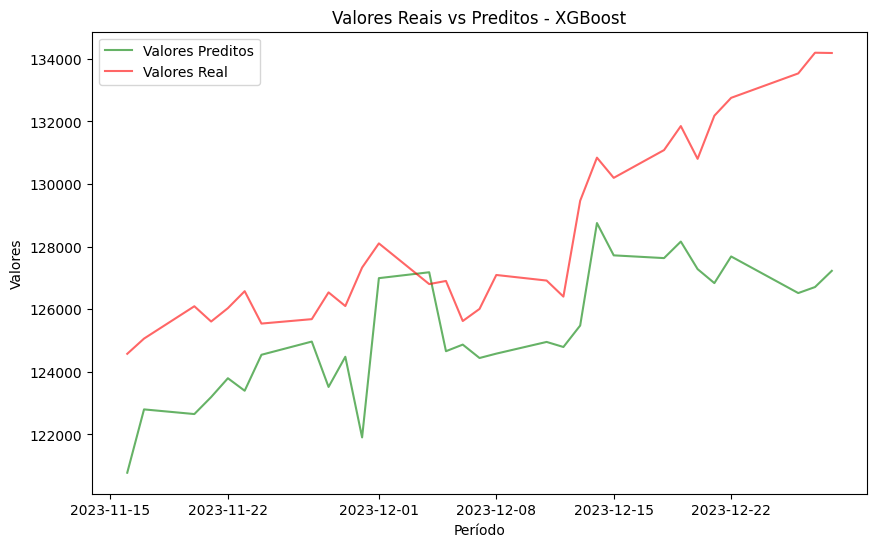

In [413]:
plt.figure(figsize=(10, 6))

plt.plot(pd2['Date'],preds, label="Valores Preditos", color="Green", alpha=0.6)
plt.plot(pd2['Date'],y_test, label="Valores Real", color="red", alpha=0.6)

plt.title("Valores Reais vs Preditos - XGBoost")
plt.xlabel("Período")
plt.ylabel("Valores")
plt.legend()

plt.show()

Nesta visualização, podemos observar quais features foram mais utilizadas no modelo XGBoost. Como esperado, a feature "Abertura" é a mais destacada, apresentando o maior F score. Isso indica que ela teve um papel fundamental nas previsões. Essa relevância se alinha com a forte correlação observada entre "Abertura" e a variável target "Fechamento" (Close).

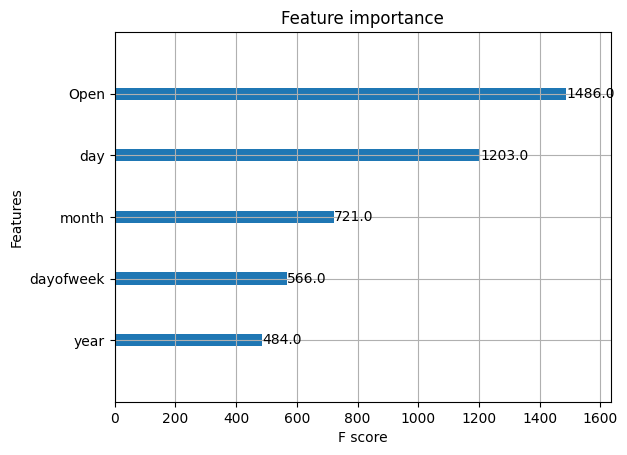

In [414]:
xgb.plot_importance(reg, importance_type='weight')
plt.show()

## 6.0 Conclusão

Após a análise dos resultados obtidos pelos diferentes modelos, observamos que o **SARIMAX** se destaca como o modelo mais preciso para a previsão do fechamento da IBOVESPA, apresentando os melhores resultados em todas as métricas (MAE, MSE e MAPE):

### SARIMAX:
- **MAE:** 1033.80
- **MSE:** 1,647,890.03
- **MAPE:** 0.80%

Sua capacidade de incorporar variáveis exógenas, como "Abertura", e de capturar a sazonalidade da série temporal foram fatores determinantes para essa performance superior.

O **SARIMA**, embora tenha apresentado resultados positivos, ficou atrás do SARIMAX, com métricas que indicam um desempenho inferior, possivelmente devido à ausência de variáveis exógenas:

### SARIMA:
- **MAE:** 1863.50
- **MSE:** 5,334,846.36
- **MAPE:** 1.43%

O **XGBoost** apresentou um desempenho razoável, com métricas intermediárias entre o SARIMAX e o SARIMA:

### XGBoost:
- **MAE:** 3078.00
- **MSE:** 12,983,180.53
- **MAPE:** 2.37%

Entretanto, sua complexidade o torna mais suscetível a overfitting se não for devidamente regularizado.

O **ARIMA** teve o pior desempenho entre os modelos analisados, com métricas significativamente mais altas, indicando que este modelo não é a melhor escolha para o problema específico em questão:

### ARIMA:
- **MAE:** 4381.07
- **MSE:** 26,737,525.46
- **MAPE:** 3.37%

Com base nas métricas e nas visualizações gráficas das previsões em comparação com os valores reais de fechamento, ficou claro que o modelo **SARIMAX** é a melhor escolha para o nosso problema. Ele apresentou o melhor equilíbrio entre ajuste e capacidade preditiva, capturando com maior precisão os padrões sazonais e as dependências temporais dos dados.
